In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from datasets.penn import Penn as Dataset
# ds = Dataset()

In [3]:
import tensorflow as tf
import os, sys
import matplotlib.pyplot as plt

sys.path.append('/scratch/ua349/pose/tf/ver1')
# from model import vgg_block, stage1_block, stageT_block
# from components import vgg_block, stage1_block, stageT_block

# sess = tf.Session()

/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
weight_decay = 5e-4
BSIZE = 16
TEST_EVERY = 10
VISUALIZE_EVERY = 100
ITERS = 10000

base_lr = 4e-5 # 2e-5
momentum = 0.9
lr_policy =  "step"
gamma = 0.333
stepsize = 136106 #68053   // after each stepsize iterations update learning rate: lr=lr*gamma
max_iter = 200000 # 600000

TIME_STEPS = 1

stages = 6
np_branch1 = 38
np_branch2 = 19
IMSIZE = 368
OUTSIZE = 46

In [7]:
from keras.models import Model, Sequential
from keras.layers.merge import Concatenate
from keras.layers import Input, Lambda, LSTM, Reshape, TimeDistributed, Dense, ConvLSTM2D
# from model.cmu_model import *
from components import *


img_input_shape = (TIME_STEPS, IMSIZE, IMSIZE, 3)
heat_mask_shape = (TIME_STEPS, OUTSIZE, OUTSIZE, 19)
# flat_shape = (OUTSIZE * OUTSIZE * np_branch2,)
# LSTM_CELLS = 1024

# print('Flattened dim: %d' % flat_shape[0])
# print('LSTM-size: %d x %d = %d' % (flat_shape[0], LSTM_CELLS, LSTM_CELLS * flat_shape[0]))



In [9]:
outputs = []

img_input = Input(shape=img_input_shape)
heat_mask = Input(shape=heat_mask_shape)
inputs = [img_input, heat_mask]

img_normalized = Lambda(lambda x: x / 256 - 0.5)
normed = TimeDistributed(img_normalized)(img_input)

# Vgg layers
stage0_out = vgg_block(normed, weight_decay)

carry = stage1_block(stage0_out, np_branch2, 2, weight_decay)
masked = apply_mask(carry, heat_mask, np_branch2, 1, 2)
outputs.append(masked)

# carry = TimeDistributed(Reshape(flat_shape))(carry)

# carry = TimeDistributed(Dense(1024))(carry)
# carry = LSTM(flat_shape[0], input_shape=flat_shape, return_sequences=True)(carry)


# carry = LSTM(LSTM_CELLS, input_shape=flat_shape, return_sequences=True)(carry)
# carry = TimeDistributed(Dense(flat_shape[0]))(carry)

# carry = TimeDistributed(Reshape(heat_mask_shape[1:]))(carry)

# carry = ConvLSTM2D(
#     filters=np_branch2,
#     kernel_size=(3, 3),
#     padding='same',
#     return_sequences=True)(carry)

carry = Concatenate()([carry, stage0_out])

carry = ConvLSTM2D(
    filters=np_branch2,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=True)(carry)

carry = ConvLSTM2D(
    filters=np_branch2,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=True)(carry)

START_AT = 2
FILTER_STAGES = 6
for sn in range(START_AT, FILTER_STAGES + 1):
    
    carry = stageT_block(carry, np_branch2, sn, 2, weight_decay)

    masked = apply_mask(carry, heat_mask, np_branch2, sn, 2)
    outputs.append(masked)
    
    if sn < FILTER_STAGES:
        # don't concatenate final output
        carry = Concatenate()([carry, stage0_out])

model = Model(inputs=inputs, outputs = outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1, 368, 368,  0                                            
__________________________________________________________________________________________________
time_distributed_140 (TimeDistr (None, 1, 368, 368,  0           input_5[0][0]                    
__________________________________________________________________________________________________
time_distributed_141 (TimeDistr (None, 1, 368, 368,  1792        time_distributed_140[0][0]       
__________________________________________________________________________________________________
time_distributed_142 (TimeDistr (None, 1, 368, 368,  0           time_distributed_141[0][0]       
__________________________________________________________________________________________________
time_distr

In [ ]:
# from training.train_pose import *
import re

def get_lr_multipliers(model):
    """
    Setup multipliers for stageN layers (kernel and bias)

    :param model:
    :return: dictionary key: layer name , value: multiplier
    """
    lr_mult = dict()
    for layer in model.layers:

        if isinstance(layer, TimeDistributed) and isinstance(layer.layer, Conv2D):
            layer = layer.layer
            # stage = 1
            if re.match("Mconv\d_stage1.*", layer.name):
                kernel_name = layer.weights[0].name
                bias_name = layer.weights[1].name
                lr_mult[kernel_name] = 1
                lr_mult[bias_name] = 2

            # stage > 1
            elif re.match("Mconv\d_stage.*", layer.name):
                kernel_name = layer.weights[0].name
                bias_name = layer.weights[1].name
                lr_mult[kernel_name] = 4
                lr_mult[bias_name] = 8

            # vgg
            else:
                kernel_name = layer.weights[0].name
                bias_name = layer.weights[1].name
                lr_mult[kernel_name] = 1
                lr_mult[bias_name] = 2

    return lr_mult


lr_multipliers = get_lr_multipliers(model)

In [ ]:
# configure callbacks
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, CSVLogger, TensorBoard
from training.optimizers import MultiSGD
from training.dataset import get_dataflow, batch_dataflow
import math

weights_best_file = "weights.best.h5"
training_log = "training.csv"
logs_dir = "./logs"

def step_decay(epoch, iterations_per_epoch):
    """
    Learning rate schedule - equivalent of caffe lr_policy =  "step"

    :param epoch:
    :param iterations_per_epoch:
    :return:
    """
    initial_lrate = base_lr
    steps = epoch * iterations_per_epoch

    lrate = initial_lrate * math.pow(gamma, math.floor(steps/stepsize))

    return lrate


from functools import partial
iterations_per_epoch = 110000 // BSIZE
_step_decay = partial(step_decay,
                      iterations_per_epoch=iterations_per_epoch
                      )
lrate = LearningRateScheduler(_step_decay)
checkpoint = ModelCheckpoint('heat.best.h5', monitor='loss',
                             verbose=0, save_best_only=False,
                             save_weights_only=True, mode='min', period=1)
csv_logger = CSVLogger(training_log, append=True)
tb = TensorBoard(log_dir=logs_dir, histogram_freq=0, write_graph=True,
                 write_images=False)

callbacks_list = [lrate, checkpoint, csv_logger, tb]

# sgd optimizer with lr multipliers

multisgd = MultiSGD(lr=base_lr, momentum=momentum, decay=0.0,
                    nesterov=False, lr_mult=lr_multipliers)


In [ ]:
# start training
import keras.backend as K
def get_loss_funcs():
    """
    Euclidean loss as implemented in caffe
    https://github.com/BVLC/caffe/blob/master/src/caffe/layers/euclidean_loss_layer.cpp
    :return:
    """
    def _eucl_loss(x, y):
        return K.sum(K.square(x - y)) / BSIZE / 2

    losses = {}
    losses["weight_stage1_L2"] = _eucl_loss
    losses["weight_stage2_L2"] = _eucl_loss
    losses["weight_stage3_L2"] = _eucl_loss
    losses["weight_stage4_L2"] = _eucl_loss
    losses["weight_stage5_L2"] = _eucl_loss
    losses["weight_stage6_L2"] = _eucl_loss

    return losses


loss_funcs = get_loss_funcs()

In [ ]:
# model.compile(loss=loss_funcs, optimizer=multisgd, metrics=["accuracy"])
model.compile(loss=loss_funcs, optimizer=multisgd, metrics=[])

In [10]:
from tensorpack.dataflow.common import BatchData, MapData
from training.dataset import get_dataflow
import numpy as np

DATA_DIR = '/beegfs/ua349/lstm/coco'

def batch_dataflow(df, batch_size):
    """
    The function builds batch dataflow from the input dataflow of samples

    :param df: dataflow of samples
    :param batch_size: batch size
    :return: dataflow of batches
    """
    df = BatchData(df, batch_size, use_list=False)
#     print('hello!')
#     df = MapData(df, lambda x: (
#         [x[0], x[2]],
#         [x[4], x[4], x[4], x[4], x[4], x[4]])
#                  )
    df = MapData(df, lambda x: (
        [
            np.stack([x[0]] * TIME_STEPS, axis=1),
            np.stack([x[2]] * TIME_STEPS, axis=1)
        ],
        [np.stack([x[4]] * TIME_STEPS, axis=1)] * 6)
#         [
#             np.stack([x[4]] * TIME_STEPS, axis=1),
#             x[4],
#             x[4],
#             x[4],
#             x[4],
#             x[4]
#         ])
                 )
    df.reset_state()
    return df


def gen(df):
    while True:
        for i in df.get_data():
            yield i
            
df = get_dataflow(
    annot_path='%s/annotations/person_keypoints_train2017.json' % DATA_DIR,
    img_dir='%s/train2017/' % DATA_DIR)
train_samples = df.size()
print('Collected %d val samples...' % train_samples)
train_df = batch_dataflow(df, BSIZE)
train_gen = gen(train_df)

loading annotations into memory...
Done (t=8.47s)
creating index...
index created!
Loading image annot 117000/118287
[0713 18:16:22 @parallel.py:290] [PrefetchDataZMQ] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.
Collected 119707 val samples...


In [12]:
print(model.inputs)
print(model.outputs)

import matplotlib.pyplot as plt

[<tf.Tensor 'input_5:0' shape=(?, 1, 368, 368, 3) dtype=float32>, <tf.Tensor 'input_6:0' shape=(?, 1, 46, 46, 19) dtype=float32>]
[<tf.Tensor 'weight_stage1_L2_2/mul:0' shape=(?, 1, 46, 46, 19) dtype=float32>, <tf.Tensor 'weight_stage2_L2_1/mul:0' shape=(?, 1, 46, 46, 19) dtype=float32>, <tf.Tensor 'weight_stage3_L2_1/mul:0' shape=(?, 1, 46, 46, 19) dtype=float32>, <tf.Tensor 'weight_stage4_L2_1/mul:0' shape=(?, 1, 46, 46, 19) dtype=float32>, <tf.Tensor 'weight_stage5_L2_1/mul:0' shape=(?, 1, 46, 46, 19) dtype=float32>, <tf.Tensor 'weight_stage6_L2_1/mul:0' shape=(?, 1, 46, 46, 19) dtype=float32>]


In [14]:
# one = None
for batch_in, batch_out in train_gen:
    print(batch_in[0].shape)
#     pass
    break

# print(batch_in


(16, 1, 368, 368, 3)


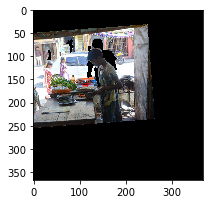

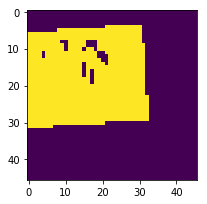

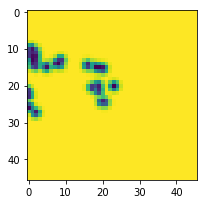

In [17]:
imgs = batch_in[0][0]

plt.figure(figsize=(14, 10))
for ii in range(TIME_STEPS):
    plt.subplot(1, 4, ii+1)
    img = (imgs[ii].astype(np.float32)/255).copy()
    cop = img.copy()
    img[:, :, 0] = cop[:, :, 2]
    img[:, :, 2] = cop[:, :, 0]
    plt.imshow(img) 
plt.show()
plt.close()


masks = batch_in[1][0]

plt.figure(figsize=(14, 10))
for ii in range(TIME_STEPS):
    plt.subplot(1, 4, ii+1)
    plt.imshow(np.sum(masks[ii], axis=-1)) 
plt.show()
plt.close()


labels = batch_out[0][0]

plt.figure(figsize=(14, 10))
for ii in range(TIME_STEPS):
    plt.subplot(1, 4, ii+1)
#     plt.imshow(np.sum(labels[ii].astype(np.float32), axis=-1)) 
    plt.imshow(labels[ii][:, :, -1].astype(np.float32)) 
plt.show()
plt.close()

In [ ]:
print('Just try starting fit.')
print('(Running fit in jupyter will cause a crash)')

model.fit_generator(train_gen,
                    steps_per_epoch=1,
                    epochs=1,
                    callbacks=callbacks_list,
                    # validation_data=val_di,
                    # validation_steps=val_samples // batch_size,
                    use_multiprocessing=False,
                    initial_epoch=0,
                    verbose=1)

raise Exception('Continue work in a .py file')